### Bill & Melinda Gates Foundation Dataset - Exploratory Data Analytics
### ------------------------------------------------------------
#### Objective:
#####   - Load CSV or Excel dataset
#####   - Clean and preprocess data
#####   - Remove duplicates
#####   - Summarize and visualize data

**Purpose:** This notebook reads a BMGF grants file (CSV or Excel), cleans and deduplicates the data, and produces a few basic exploratory tables and visualizations. Follow the cells sequentially.

## 1 — Setup

Install required packages if you don't have them:

```bash
pip install pandas matplotlib openpyxl xlrd pyarrow
```

Then run the cell below to import packages.

In [62]:

!pip install geopandas plotly shapely pyproj --quiet



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:

import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import geopandas as gpd
import plotly.express as px

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 200)

print('pandas:', pd.__version__)
print('numpy:', np.__version__)
# print('matplotlib:', plt.__version__)

pandas: 2.2.3
numpy: 1.26.4


## 2 — Load the data (CSV or Excel)

Place your dataset file in the same folder as this notebook or provide the full path. Supported extensions: `.csv`, `.xls`, `.xlsx`.

Update `DATA_PATH` below to the filename if needed.

In [12]:
# Update this path to your file if needed
# Path to your dataset (update this if needed)
file_path = "BMGF Grants.csv"  # e.g. "Bill_Melinda_Gates_Foundation_Grants.xlsx"

# Detect and read file
p = pd.Path(file_path) if hasattr(pd, "Path") else type('p', (), {'name': os.path.basename(file_path)})

if file_path.endswith(".csv"):
    df = pd.read_csv(file_path, skiprows=1)
elif file_path.endswith((".xls", ".xlsx")):
    df = pd.read_excel(file_path, skiprows=1)
else:
    raise ValueError("Unsupported file format. Please use CSV or Excel.")

print('Loaded file:', p.name)
print('Shape:', df.shape)
df.head(5)


"""
The dataset contains information about grants made by the Bill & Melinda Gates Foundation. The columns may include details such as:
- Grant ID
- Grantee Name
- Grant Amount
- Grant Date
- Program Area
- Country/Region
- Status
- Description

The whole dataset has 38742 records with 13 data attributes.
"""

Loaded file: BMGF Grants.csv
Shape: (38741, 13)


'\nThe dataset contains information about grants made by the Bill & Melinda Gates Foundation. The columns may include details such as:\n- Grant ID\n- Grantee Name\n- Grant Amount\n- Grant Date\n- Program Area\n- Country/Region\n- Status\n- Description\n\nThe whole dataset has 38742 records with 13 data attributes.\n'

## 3 — Quick inspection & raw fixes

Examine columns, value counts for key fields, and clean whitespace from column names.

In [13]:
# Inspect columns and sample values
print('Columns:')
for c in df.columns:
    print('-', repr(c))

# Clean column names (strip whitespace)
df.columns = [str(c).strip() for c in df.columns]

# Show cleaned names and first rows
print('\nCleaned column names:')
for c in df.columns:
    print('-', c)

df.head(5)

Columns:
- 'GRANT ID'
- 'GRANTEE'
- 'PURPOSE'
- 'DIVISION'
- 'DATE COMMITTED'
- 'DURATION (MONTHS)'
- 'AMOUNT COMMITTED'
- 'GRANTEE WEBSITE'
- 'GRANTEE CITY'
- 'GRANTEE STATE'
- 'GRANTEE COUNTRY'
- 'REGION SERVED'
- 'TOPIC'

Cleaned column names:
- GRANT ID
- GRANTEE
- PURPOSE
- DIVISION
- DATE COMMITTED
- DURATION (MONTHS)
- AMOUNT COMMITTED
- GRANTEE WEBSITE
- GRANTEE CITY
- GRANTEE STATE
- GRANTEE COUNTRY
- REGION SERVED
- TOPIC


,GRANT ID,GRANTEE,PURPOSE,DIVISION,DATE COMMITTED,DURATION (MONTHS),AMOUNT COMMITTED,GRANTEE WEBSITE,GRANTEE CITY,GRANTEE STATE,GRANTEE COUNTRY,REGION SERVED,TOPIC
0,INV-002690,World Health Organization,to reduce cholera's disease burden in both epi...,Global Health,2021-02,16.0,1078614.0,http://www.who.int,Geneva,NaN,Switzerland,GLOBAL,"Enterics, Diagnostics, Genomics & Epidemiology"
1,INV-003934,Smithsonian Institution,to endow the museum’s permanent collection of ...,Executive,2021-02,59.0,1500000.0,http://www.si.edu/,Washington,District of Columbia,United States,AMERICA,Community Engagement Grantmaking
2,INV-004622,Praedicare Inc,to evaluate novel TB drug combinations in the ...,Global Health,2021-02,15.0,631733.0,http://www.praedicarelabs.com,Dallas,Texas,United States,AMERICA,Tuberculosis
3,INV-015740,Africa Resource Center for Excellence in Suppl...,to strengthen supply chain systems performance...,Gender Equality|Global Development,2021-02,59.0,4955723.0,NaN,Abuja,Abuja Federal Capital Territory,Nigeria,AFRICA,Family Planning|Global Health and Development ...
4,INV-016370,International Centre for Diarrhoeal Disease Re...,"to develop shelf-stable, locally-sourced, micr...",Gender Equality,2021-02,61.0,3495385.0,http://www.icddrb.org,Dhaka,NaN,Bangladesh,ASIA,"Maternal, Newborn, Child Nutrition and Health"


## 4 — Normalize column names to snake_case

We convert column names to lower snake_case to make later code consistent. A small mapping is provided for common columns in the BMGF dataset.

In [14]:
import re

def to_snake(s):
    s = str(s).strip()
    s = re.sub(r"[\s\-\/]+", '_', s)
    s = re.sub(r"[^0-9a-zA-Z_]+", '', s)
    s = re.sub(r'__+', '_', s)
    return s.lower().strip('_')

orig_cols = list(df.columns)
new_cols = [to_snake(c) for c in orig_cols]
rename_map = dict(zip(orig_cols, new_cols))

df.rename(columns=rename_map, inplace=True)
print('Renamed columns mapping (sample):')
for o,n in list(rename_map.items())[:20]:
    print(f"{o!r} -> {n!r}")

# If there are common fields we expect in the dataset, create friendly aliases
aliases = {
    'grant_id': 'grant_id',
    'grantee': 'grantee',
    'purpose': 'purpose',
    'division': 'division',
    'date_committed': 'date_committed',
    'duration_months': 'duration_months',
    'amount_committed': 'amount_committed',
    'grantee_website': 'grantee_website',
    'grantee_city': 'grantee_city',
    'grantee_state': 'grantee_state',
    'grantee_country': 'grantee_country',
    'region_served': 'region_served',
    'topic': 'topic'
}

# ensure alias keys exist; this does not rename again but documents expected names
present = {k:v for k,v in aliases.items() if v in df.columns}
print('\nDetected expected columns:', list(present.keys()))

df.head(3)

Renamed columns mapping (sample):
'GRANT ID' -> 'grant_id'
'GRANTEE' -> 'grantee'
'PURPOSE' -> 'purpose'
'DIVISION' -> 'division'
'DATE COMMITTED' -> 'date_committed'
'DURATION (MONTHS)' -> 'duration_months'
'AMOUNT COMMITTED' -> 'amount_committed'
'GRANTEE WEBSITE' -> 'grantee_website'
'GRANTEE CITY' -> 'grantee_city'
'GRANTEE STATE' -> 'grantee_state'
'GRANTEE COUNTRY' -> 'grantee_country'
'REGION SERVED' -> 'region_served'
'TOPIC' -> 'topic'

Detected expected columns: ['grant_id', 'grantee', 'purpose', 'division', 'date_committed', 'duration_months', 'amount_committed', 'grantee_website', 'grantee_city', 'grantee_state', 'grantee_country', 'region_served', 'topic']


,grant_id,grantee,purpose,division,date_committed,duration_months,amount_committed,grantee_website,grantee_city,grantee_state,grantee_country,region_served,topic
0,INV-002690,World Health Organization,to reduce cholera's disease burden in both epi...,Global Health,2021-02,16.0,1078614.0,http://www.who.int,Geneva,NaN,Switzerland,GLOBAL,"Enterics, Diagnostics, Genomics & Epidemiology"
1,INV-003934,Smithsonian Institution,to endow the museum’s permanent collection of ...,Executive,2021-02,59.0,1500000.0,http://www.si.edu/,Washington,District of Columbia,United States,AMERICA,Community Engagement Grantmaking
2,INV-004622,Praedicare Inc,to evaluate novel TB drug combinations in the ...,Global Health,2021-02,15.0,631733.0,http://www.praedicarelabs.com,Dallas,Texas,United States,AMERICA,Tuberculosis


## 5 — Parse dates and amounts

Convert `date_committed` to datetime (best-effort) and `amount_committed` to numeric. We handle common formats (commas, currency symbols).

In [15]:
from dateutil import parser

# Parse date_committed (keep original in case of errors)
df['date_committed_raw'] = df.get('date_committed')

def parse_date(x):
    if pd.isna(x):
        return pd.NaT
    try:
        # Many BMGF dates are YYYY-MM or YYYY-MM-DD. parser handles both
        return pd.to_datetime(str(x), infer_datetime_format=True, errors='coerce')
    except Exception:
        return pd.NaT

if 'date_committed' in df.columns:
    df['date_committed'] = df['date_committed'].apply(parse_date)
    df['year_committed'] = df['date_committed'].dt.year

# Normalize amount_committed
if 'amount_committed' in df.columns:
    def parse_amount(x):
        if pd.isna(x):
            return np.nan
        s = str(x).strip()
        # Remove common non-numeric characters
        s = s.replace(',', '')
        s = s.replace('$', '')
        s = s.replace('USD', '')
        s = s.replace(' ', '')
        try:
            return float(s)
        except Exception:
            return np.nan
    df['amount_committed_raw'] = df.get('amount_committed')
    df['amount_committed'] = df['amount_committed'].apply(parse_amount)

# Quick check
print('Date parsing:')
print(df[['date_committed_raw', 'date_committed']].head(5))
print('\nAmount parsing:')
print(df[['amount_committed_raw', 'amount_committed']].head(5))

C:\Users\STUDENT\AppData\Local\Temp\ipykernel_10908\16112560.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(str(x), infer_datetime_format=True, errors='coerce')


Date parsing:
  date_committed_raw date_committed
0            2021-02     2021-02-01
1            2021-02     2021-02-01
2            2021-02     2021-02-01
3            2021-02     2021-02-01
4            2021-02     2021-02-01

Amount parsing:
   amount_committed_raw  amount_committed
0             1078614.0         1078614.0
1             1500000.0         1500000.0
2              631733.0          631733.0
3             4955723.0         4955723.0
4             3495385.0         3495385.0


## 6 — Country and region normalization (basic)

This cell performs light normalization: trim spaces, uppercase country names, and split multi-region values (keeping the first). For production you'd use ISO code mapping (pycountry).

In [16]:
# Normalize country and region
if 'grantee_country' in df.columns:
    df['grantee_country'] = df['grantee_country'].astype(str).str.strip()
    df.loc[df['grantee_country'].str.lower().isin(['nan','none','', 'nan']), 'grantee_country'] = np.nan

if 'region_served' in df.columns:
    df['region_served'] = df['region_served'].astype(str).str.strip()
    # Keep the first region if there are pipes e.g. AFRICA|ASIA
    df['region_primary'] = df['region_served'].str.split('|').str[0]

# show unique countries and regions (top 10)
print('Top countries:')
print(df['grantee_country'].value_counts(dropna=True).head(10))
print('\nTop regions:')
print(df['region_primary'].value_counts(dropna=True).head(10))

Top countries:
grantee_country
United States     28901
United Kingdom     1620
Switzerland        1036
India               929
South Africa        637
Kenya               515
China               403
Nigeria             395
Canada              387
Australia           281
Name: count, dtype: int64

Top regions:
region_primary
AMERICA    19482
GLOBAL      8718
AFRICA      7385
ASIA        2786
EUROPE       333
OCEANIA       36
nan            1
Name: count, dtype: int64


## 7 — Remove duplicates

We try two approaches:
1. Deduplicate by `grant_id` if present (preferred)
2. Otherwise, deduplicate by a combination of key columns (grantee, date_committed, amount_committed)

We will keep the first occurrence and log how many rows were dropped.

In [17]:
initial_rows = len(df)
if 'grant_id' in df.columns:
    df = df.sort_values(by=['grant_id', 'date_committed'])
    df = df.drop_duplicates(subset=['grant_id'], keep='first')
    method = 'grant_id'
else:
    key_cols = [c for c in ['grantee','date_committed','amount_committed'] if c in df.columns]
    df = df.sort_values(by=key_cols)
    df = df.drop_duplicates(subset=key_cols, keep='first')
    method = 'composite'

removed = initial_rows - len(df)
print(f'Removed {removed} duplicate rows using method: {method}. Remaining rows: {len(df)}')

# Show any duplicates still present for grant_id (should be none)
if 'grant_id' in df.columns:
    dup = df[df.duplicated(subset=['grant_id'], keep=False)]
    print('Remaining duplicates (grant_id):', dup.shape[0])

# Show cleaned head
df.head(5)

""" 
We don't have duplication in our dataset
Which means each grant_id is unique after cleaning.

"""

Removed 0 duplicate rows using method: grant_id. Remaining rows: 38741
Remaining duplicates (grant_id): 0


,grant_id,grantee,purpose,division,date_committed,duration_months,amount_committed,grantee_website,grantee_city,grantee_state,grantee_country,region_served,topic,date_committed_raw,year_committed,amount_committed_raw,region_primary
23886,INV-000138,University of Wisconsin,to illuminate the applied learning component o...,U.S. Program,2019-06-01,36.0,1832327.0,http://www.wisc.edu/,Madison,Wisconsin,United States,AMERICA,Postsecondary Education,2019-06,2019.0,1832327.0,AMERICA
22736,INV-000202,Johns Hopkins University Bloomberg School of P...,to promote the use of rotavirus vaccines throu...,Global Health,2019-10-01,43.0,740930.0,http://www.jhsph.edu,Baltimore,Maryland,United States,GLOBAL,"Enterics, Diagnostics, Genomics & Epidemiology",2019-10,2019.0,740930.0,GLOBAL
23718,INV-000220,National Association of State Boards of Education,to provide for general operating support,Global Policy and Advocacy,2019-08-01,9.0,25000.0,http://www.nasbe.org,Alexandria,Virginia,United States,AMERICA,Public Awareness and Analysis,2019-08,2019.0,25000.0,AMERICA
24269,INV-000288,Higher Learning Advocates Inc,to provide for General Operating Support,U.S. Program,2019-02-01,12.0,500000.0,https://www.higherlearningadvocates.org/,Washington,District of Columbia,United States,AMERICA,Postsecondary Education,2019-02,2019.0,500000.0,AMERICA
22575,INV-000337,"MDC, Inc.",to provide for general operating support,U.S. Program,2019-07-01,12.0,75000.0,http://www.mdcinc.org,Durham,North Carolina,United States,AMERICA,Postsecondary Education,2019-07,2019.0,75000.0,AMERICA


## 8 — Basic exploratory analysis & visualizations

Simple charts: total funding by year, top topics by total funding, and top grantees by funding amount.

Identify Categorical vs Numerical Columns

In [55]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

# Identify numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical columns:", numerical_cols)


Categorical columns: ['grant_id', 'grantee', 'purpose', 'division', 'grantee_website', 'grantee_city', 'grantee_state', 'grantee_country', 'region_served', 'topic', 'date_committed_raw', 'region_primary']
Numerical columns: ['duration_months', 'amount_committed', 'year_committed', 'amount_committed_raw']


C:\Users\STUDENT\AppData\Local\Temp\ipykernel_10908\626144281.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




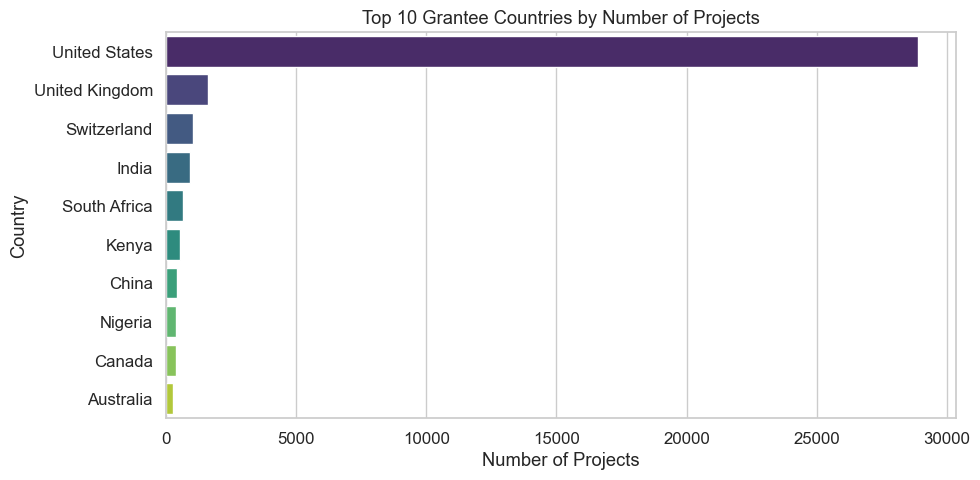

In [59]:
# Example 1: Top 10 grantee countries by number of projects
top_countries = df['grantee_country'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title("Top 10 Grantee Countries by Number of Projects")
plt.xlabel("Number of Projects")
plt.ylabel("Country")
plt.tight_layout()
plt.show()



### Geographical visualzation of our dataset



In [64]:


# Sum funding by country (you can use your real data)
country_funding = (
    df.groupby('grantee_country')['amount_committed']
    .sum()
    .reset_index()
    .rename(columns={'grantee_country': 'country', 'amount_committed': 'total_funding_usd'})
)

# Plot
fig = px.choropleth(
    country_funding,
    locations='country',
    locationmode='country names',
    color='total_funding_usd',
    hover_name='country',
    color_continuous_scale='Viridis',
    title='Total Gates Foundation Funding by Country (USD) - Visualization',
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth'),
    coloraxis_colorbar=dict(title='USD Funding (log scale)'),
)
fig.show()


In [67]:
# # Example: Boxplot of funding per division
# plt.figure(figsize=(12,6))
# sns.boxplot(x='division', y='amount_committed', data=df)
# plt.title("📦 Funding Distribution per Division")
# plt.xlabel("Division")
# plt.ylabel("Amount Committed (USD)")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


Yearly Funding Overview (in USD):


,year_committed,amount_committed
0,1994.0,1.000000e+06
1,1995.0,2.876207e+07
2,1996.0,1.456150e+07
3,1997.0,3.620140e+07
4,1998.0,2.444608e+08
5,1999.0,2.592474e+09
6,2000.0,1.321793e+09
7,2001.0,7.918284e+08
8,2002.0,7.233458e+08
9,2003.0,1.270382e+09


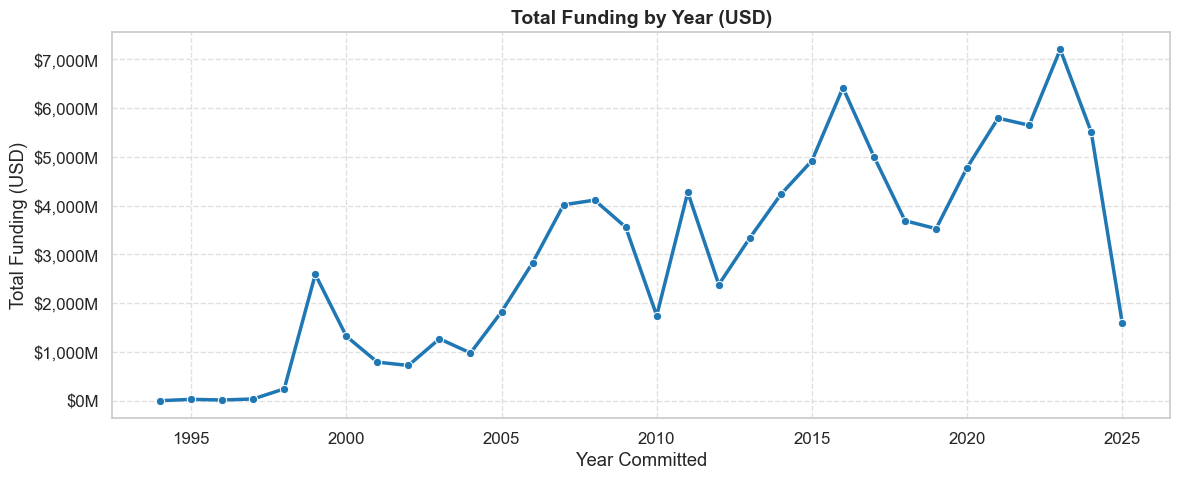

In [52]:
# Set general style
sns.set_theme(style="whitegrid", font_scale=1.1)

# Format numbers with commas and USD
def format_usd(x, pos):
    return f'${x/1e6:,.0f}M'  # Show in millions for readability

usd_formatter = mtick.FuncFormatter(format_usd)

# Total Funding by Year
if 'year_committed' in df.columns and 'amount_committed' in df.columns:
    yearly = (
        df.groupby('year_committed', dropna=True)['amount_committed']
        .sum()
        .reset_index()
        .sort_values('year_committed')
    )
    
    print("Yearly Funding Overview (in USD):")
    display(yearly.head(10))
    
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=yearly, x='year_committed', y='amount_committed', marker='o', linewidth=2.5, color='#1f77b4')
    plt.title('Total Funding by Year (USD)', fontsize=14, fontweight='bold')
    plt.xlabel('Year Committed')
    plt.ylabel('Total Funding (USD)')
    plt.gca().yaxis.set_major_formatter(usd_formatter)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print('year_committed or amount_committed column missing - cannot plot yearly trend')


Top 10 Topics by Total Funding (USD):


,topic,amount_committed
702,Polio,8.689419e+09
2,Agricultural Development,6.941739e+09
547,Global Health and Development Public Awareness...,5.135027e+09
605,HIV,4.853945e+09
647,Malaria,4.691659e+09
622,K-12 Education,4.666370e+09
747,Vaccine Delivery,3.729026e+09
82,Delivery of Solutions to Improve Global Health,3.600948e+09
709,Postsecondary Education,3.020711e+09
742,Tuberculosis,2.121568e+09


C:\Users\STUDENT\AppData\Local\Temp\ipykernel_10908\3486785996.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




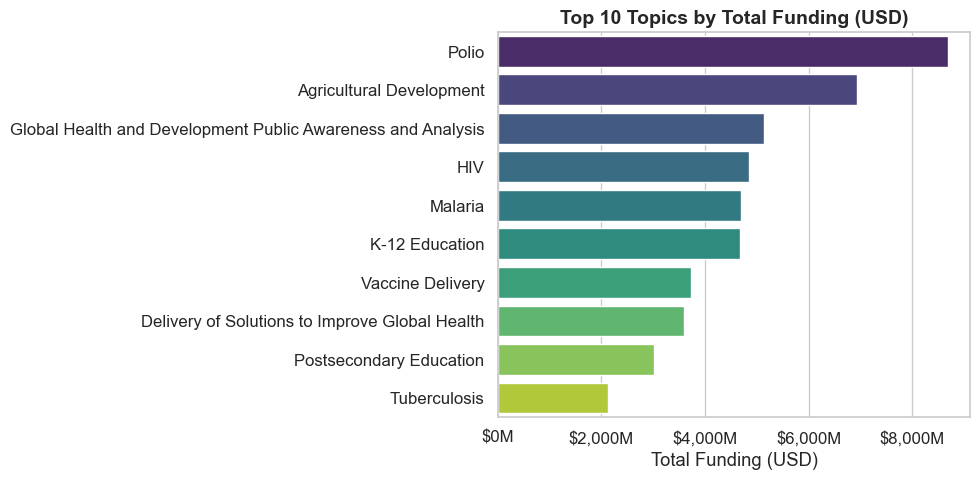

In [53]:

# Top Topics by Total Funding
if 'topic' in df.columns and 'amount_committed' in df.columns:
    top_topics = (
        df.groupby('topic', dropna=True)['amount_committed']
        .sum()
        .reset_index()
        .sort_values('amount_committed', ascending=False)
        .head(10)
    )
    
    print("Top 10 Topics by Total Funding (USD):")
    display(top_topics)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=top_topics,
        y='topic',
        x='amount_committed',
        palette='viridis'
    )
    plt.title('Top 10 Topics by Total Funding (USD)', fontsize=14, fontweight='bold')
    plt.xlabel('Total Funding (USD)')
    plt.ylabel('')
    plt.gca().xaxis.set_major_formatter(usd_formatter)
    plt.tight_layout()
    plt.show()


Top 10 Grantees by Total Funding (USD):


,grantee,amount_committed
4292,GAVI Alliance,4.954940e+09
12832,World Health Organization,4.390562e+09
11189,"The Global Fund to Fight AIDS, Tuberculosis an...",3.908006e+09
8508,PATH,3.067051e+09
11328,The Rotary Foundation of Rotary International,1.898647e+09
11753,United States Fund for UNICEF,1.886448e+09
12032,University of Washington Foundation,1.569980e+09
5629,International Bank for Reconstruction and Deve...,1.542462e+09
4343,Gates Medical Research Institute,1.322971e+09
11746,"United Negro College Fund, Inc.",1.317376e+09


C:\Users\STUDENT\AppData\Local\Temp\ipykernel_10908\2869872308.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




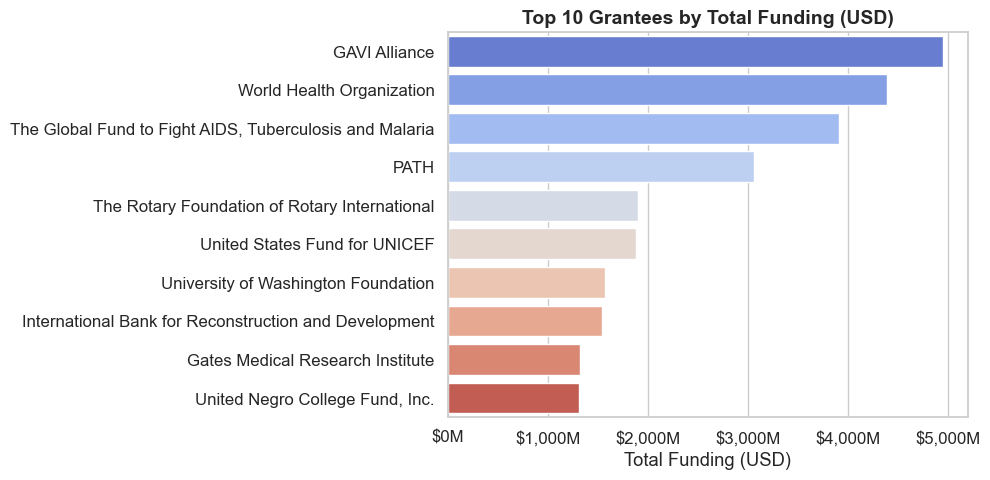

In [54]:

# Top Grantees by Total Funding
if 'grantee' in df.columns and 'amount_committed' in df.columns:
    top_grantees = (
        df.groupby('grantee', dropna=True)['amount_committed']
        .sum()
        .reset_index()
        .sort_values('amount_committed', ascending=False)
        .head(10)
    )
    
    print("Top 10 Grantees by Total Funding (USD):")
    display(top_grantees)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=top_grantees,
        y='grantee',
        x='amount_committed',
        palette='coolwarm'
    )
    plt.title('Top 10 Grantees by Total Funding (USD)', fontsize=14, fontweight='bold')
    plt.xlabel('Total Funding (USD)')
    plt.ylabel('')
    plt.gca().xaxis.set_major_formatter(usd_formatter)
    plt.tight_layout()
    plt.show()


## 9 — 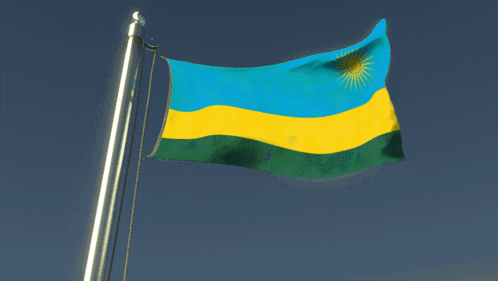 Specialized Findings: Rwanda-Focused Analysis

Total Rwanda-Related Records: 40


,grant_id,grantee,purpose,division,date_committed,duration_months,amount_committed,grantee_website,grantee_city,grantee_state,grantee_country,region_served,topic,date_committed_raw,year_committed,amount_committed_raw,region_primary
23995,INV-000692,University of Global Health Equity,This investment will support the third Women L...,Global Health,2019-05-01,9.0,500000.0,http://ughe.org/,Kigali,NaN,Rwanda,GLOBAL,"Enterics, Diagnostics, Genomics & Epidemiology",2019-05,2019.0,500000.0,GLOBAL
23232,INV-002978,Rwanda Agriculture Board,to develop a soil information service for impr...,Global Growth & Opportunity,2019-11-01,54.0,1975776.0,https://www.rab.gov.rw,Kigali,NaN,Rwanda,AFRICA,Agricultural Development,2019-11,2019.0,1975776.0,AFRICA
22528,INV-005494,BK TecHouse Limited,to facilitate adoption and scaling of an integ...,Global Growth & Opportunity,2020-12-01,41.0,2498432.0,http://www.bktechouse.rw,Kigali,City of Kigali,Rwanda,AFRICA,Agricultural Development,2020-12,2020.0,2498432.0,AFRICA
21247,INV-006217,Irembo Limited,to improve efficiency and effectiveness of dig...,Global Development,2020-11-01,37.0,980708.0,NaN,Kigali,NaN,Rwanda,AFRICA,Delivery of Solutions to Improve Global Health,2020-11,2020.0,980708.0,AFRICA
5744,INV-007067,"Ministry of Health, Rwanda",to generate rigorous evidence about the effect...,Global Growth & Opportunity,2012-07-01,66.0,1142667.0,http://www.moh.gov.rw/,Kigali,City of Kigali,Rwanda,AFRICA,"Water, Sanitation and Hygiene",2012-07,2012.0,1142667.0,AFRICA


Total Funding Committed to Rwanda: $53,807,291.00 USD
Average Grant Amount: $1,345,182.27 USD


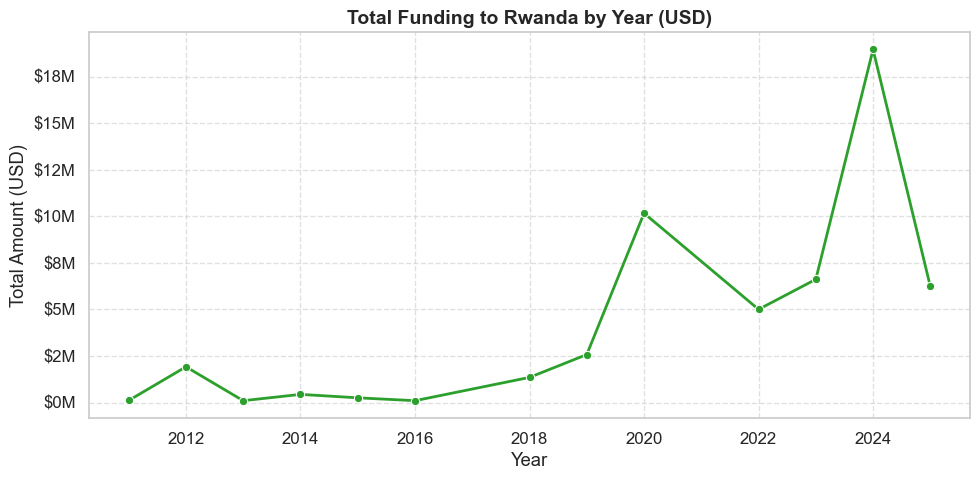

In [32]:
# 🇷🇼 Filter data for Rwanda
rwanda_df = df[df['grantee_country'].str.contains('Rwanda', case=False, na=False)]

print(f"Total Rwanda-Related Records: {rwanda_df.shape[0]}")
display(rwanda_df.head(5))

# Basic Funding Overview
total_funding = rwanda_df['amount_committed'].sum()
avg_funding = rwanda_df['amount_committed'].mean()
print(f"Total Funding Committed to Rwanda: ${total_funding:,.2f} USD")
print(f"Average Grant Amount: ${avg_funding:,.2f} USD")

# Funding Over Time
if 'year_committed' in rwanda_df.columns:
    yearly_rwanda = (
        rwanda_df.groupby('year_committed', dropna=True)['amount_committed']
        .sum()
        .reset_index()
        .sort_values('year_committed')
    )
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=yearly_rwanda, x='year_committed', y='amount_committed', marker='o', color='#2ca02c', linewidth=2)
    plt.title('Total Funding to Rwanda by Year (USD)', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Total Amount (USD)')
    plt.gca().yaxis.set_major_formatter(usd_formatter)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


""" 

Throughout 1994 to 2025, Rwanda has received varying levels of funding from the Bill & Melinda Gates Foundation [Up to 40], with notable peaks in certain years. 
The trend indicates fluctuating investment levels, reflecting the foundation's strategic focus and response to Rwanda's developmental needs over time. 


"""


C:\Users\STUDENT\AppData\Local\Temp\ipykernel_10908\1548402145.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


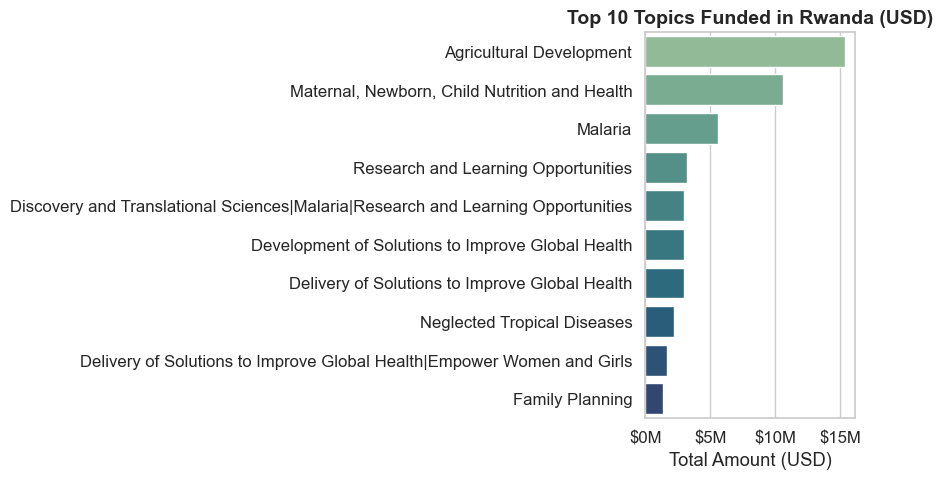

Top Topics by Total Funding:


,topic,amount_committed
0,Agricultural Development,15362318.0
13,"Maternal, Newborn, Child Nutrition and Health",10563121.0
11,Malaria,5563584.0
16,Research and Learning Opportunities,3174455.0
5,Discovery and Translational Sciences|Malaria|R...,3001385.0
3,Development of Solutions to Improve Global Health,3000000.0
1,Delivery of Solutions to Improve Global Health,2965994.0
14,Neglected Tropical Diseases,2167851.0
2,Delivery of Solutions to Improve Global Health...,1654468.0
7,Family Planning,1350022.0


In [34]:
# Top Areas of Focus Funded in Rwanda

if 'topic' in rwanda_df.columns:
    top_topics_rw = (
        rwanda_df.groupby('topic', dropna=True)['amount_committed']
        .sum()
        .reset_index()
        .sort_values('amount_committed', ascending=False)
        .head(10)
    )
    plt.figure(figsize=(9, 5))
    sns.barplot(
        data=top_topics_rw,
        y='topic',
        x='amount_committed',
        palette='crest'
    )
    plt.title('Top 10 Topics Funded in Rwanda (USD)', fontsize=14, fontweight='bold')
    plt.xlabel('Total Amount (USD)')
    plt.ylabel('')
    plt.gca().xaxis.set_major_formatter(usd_formatter)
    plt.tight_layout()
    plt.show()
    print("Top Topics by Total Funding:")
    display(top_topics_rw)

C:\Users\STUDENT\AppData\Local\Temp\ipykernel_10908\701694705.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




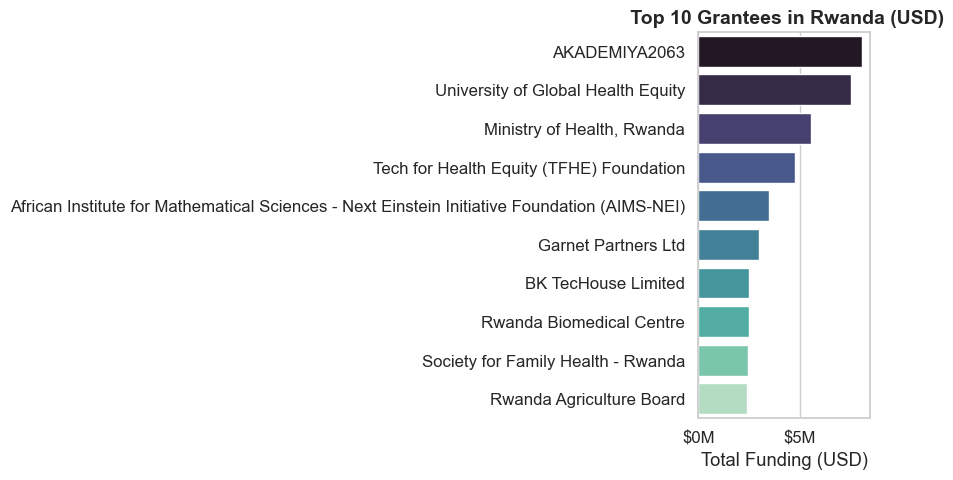

 Leading Grantee Organizations in Rwanda:


,grantee,amount_committed
0,AKADEMIYA2063,8094502.0
21,University of Global Health Equity,7546626.0
10,"Ministry of Health, Rwanda",5545174.0
20,Tech for Health Equity (TFHE) Foundation,4782720.0
1,African Institute for Mathematical Sciences - ...,3501544.0
4,Garnet Partners Ltd,3000000.0
2,BK TecHouse Limited,2498432.0
15,Rwanda Biomedical Centre,2486141.0
18,Society for Family Health - Rwanda,2435332.0
14,Rwanda Agriculture Board,2414677.0


 Rwanda-Specific Summary:
- Total Projects: 40
- Total Funding (USD): $53,807,291.00
- Avg Project Duration: 28.6 months
- Main Divisions: Global Health, Global Growth & Opportunity, Global Development, Gender Equality, Gender Equality|Global Development


In [65]:
# Top Grantees in Rwanda
if 'grantee' in rwanda_df.columns:
    top_grantees_rw = (
        rwanda_df.groupby('grantee', dropna=True)['amount_committed']
        .sum()
        .reset_index()
        .sort_values('amount_committed', ascending=False)
        .head(10)
    )
    plt.figure(figsize=(9, 5))
    sns.barplot(
        data=top_grantees_rw,
        y='grantee',
        x='amount_committed',
        palette='mako'
    )
    plt.title(' Top 10 Grantees in Rwanda (USD)', fontsize=14, fontweight='bold')
    plt.xlabel('Total Funding (USD)')
    plt.ylabel('')
    plt.gca().xaxis.set_major_formatter(usd_formatter)
    plt.tight_layout()
    plt.show()
    print(" Leading Grantee Organizations in Rwanda:")
    display(top_grantees_rw)

#  Regional Footprint Summary
print(" Rwanda-Specific Summary:")
print(f"- Total Projects: {rwanda_df.shape[0]}")
print(f"- Total Funding (USD): ${total_funding:,.2f}")
print(f"- Avg Project Duration: {rwanda_df['duration_months'].mean():.1f} months")
print(f"- Main Divisions: {', '.join(rwanda_df['division'].dropna().unique()[:5])}")


## 10 — Save cleaned data

Save the processed CSV locally (or upload to your S3 `processed/` folder if using AWS).

In [68]:
out_fname = 'bmgf_cleaned_processed.csv'
df.to_csv(out_fname, index=False)
print('Saved cleaned CSV to', out_fname)

# If you're using AWS S3, you can upload it using boto3 (example, requires AWS credentials configured):
print('\nIf you want to upload to S3, uncomment and configure the code below (requires boto3 and AWS credentials).')
print('Example:')
print("# import boto3\n# s3 = boto3.client('s3')\n# s3.upload_file(out_fname, 'your-bucket-name', 'processed/" + out_fname + "')")



Saved cleaned CSV to bmgf_cleaned_processed.csv

If you want to upload to S3, uncomment and configure the code below (requires boto3 and AWS credentials).
Example:
# import boto3
# s3 = boto3.client('s3')
# s3.upload_file(out_fname, 'your-bucket-name', 'processed/bmgf_cleaned_processed.csv')


In [69]:
# Open the cleaned file to verify
cleaned_df = pd.read_csv(out_fname)
print('\nLoaded cleaned file preview:')
display(cleaned_df.head(3))



Loaded cleaned file preview:


,grant_id,grantee,purpose,division,date_committed,duration_months,amount_committed,grantee_website,grantee_city,grantee_state,grantee_country,region_served,topic,date_committed_raw,year_committed,amount_committed_raw,region_primary
0,INV-000138,University of Wisconsin,to illuminate the applied learning component o...,U.S. Program,2019-06-01,36.0,1832327.0,http://www.wisc.edu/,Madison,Wisconsin,United States,AMERICA,Postsecondary Education,2019-06,2019.0,1832327.0,AMERICA
1,INV-000202,Johns Hopkins University Bloomberg School of P...,to promote the use of rotavirus vaccines throu...,Global Health,2019-10-01,43.0,740930.0,http://www.jhsph.edu,Baltimore,Maryland,United States,GLOBAL,"Enterics, Diagnostics, Genomics & Epidemiology",2019-10,2019.0,740930.0,GLOBAL
2,INV-000220,National Association of State Boards of Education,to provide for general operating support,Global Policy and Advocacy,2019-08-01,9.0,25000.0,http://www.nasbe.org,Alexandria,Virginia,United States,AMERICA,Public Awareness and Analysis,2019-08,2019.0,25000.0,AMERICA


## 11 — Next steps & tips

- Validate more fields (URLs, cities, numeric outliers).
- Use `pycountry` to map country names to ISO codes.
- Add logging and unit tests for your cleaning functions.
- For larger files, rewrite cleaning using PySpark or Dask.
- Integrate as AWS Lambda: package dependencies using a Lambda Layer or use container images.

---

**End of notebook.**